In [4]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt

import os
from tqdm.auto import tqdm

c:\Users\denis\anaconda3\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode provided py the Kaggle staff
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    if mask_rle == 0:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  

In [7]:
masks = pd.read_csv(r'data\train_ship_segmentations_v2.csv')
masks

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [8]:
masks = masks.fillna(0)
masks

,ImageId,EncodedPixels
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,0
231719,ffff2aa57.jpg,0
231720,ffff6e525.jpg,0
231721,ffffc50b4.jpg,0


In [9]:
# Let`s see how namy unique images are in dataset
len(masks['ImageId'].unique())

192556

In [10]:
# Let`s see how namy unique images wihout ships are in dataset
len(masks[masks['EncodedPixels'] == 0])

150000

In [11]:
# We can see the dataset is imbalanced, lets create a balanced version of masks.csv 

balanced_mask_df = pd.concat([masks[masks['EncodedPixels'] == 0].sample(frac=0.1), masks[masks['EncodedPixels'] != 0]]).sample(frac = 1)
balanced_mask_df

,ImageId,EncodedPixels
145856,a0f9526a9.jpg,0
109334,7869d5bdd.jpg,76623 1 77388 5 78153 9 78919 11 79687 11 8045...
120173,849ab5fc3.jpg,308655 4 309423 11 310191 15 310958 16 311726 ...
142790,9d8572e25.jpg,489137 6 489905 16 490673 26 491441 36 492209 ...
178713,c5683c938.jpg,548319 3 549082 8 549844 14 550607 20 551370 2...
...,...,...
48428,35e9afe12.jpg,349396 1 350163 3 350931 4 351698 6 352465 8 3...
112915,7c812db1d.jpg,454457 1 455225 3 455992 6 456760 8 457527 11 ...
87052,601bdf33e.jpg,348046 1 348813 3 349580 5 350347 7 351114 9 3...
215725,ee69b6671.jpg,542183 1 542951 2 543718 5 544485 7 545252 9 5...


In [14]:
train_img_folder = r'data\train_v2'

# A function that takes a list of ImageId and plots iamge, its masks overlap triplets
def plot_exmaples(imgid_list):
    fig, axs = plt.subplots(len(imgid_list), 3, figsize=(30, 10 * len(imgid_list)))
    if len(imgid_list) == 1:
        axs = np.expand_dims(axs, axis = 0)
    
    for i, ImageId in enumerate(imgid_list):
        img = cv2.imread(os.path.join(train_img_folder, ImageId))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

        all_masks = np.zeros((768, 768))
        for mask in img_masks:
            all_masks += rle_decode(mask)

        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
        axs[i, 2].axis('off')
        axs[i, 0].imshow(img)
        axs[i, 1].imshow(all_masks)
        axs[i, 2].imshow(img)
        axs[i, 2].imshow(all_masks, alpha=0.4)

    plt.tight_layout()
    plt.show()

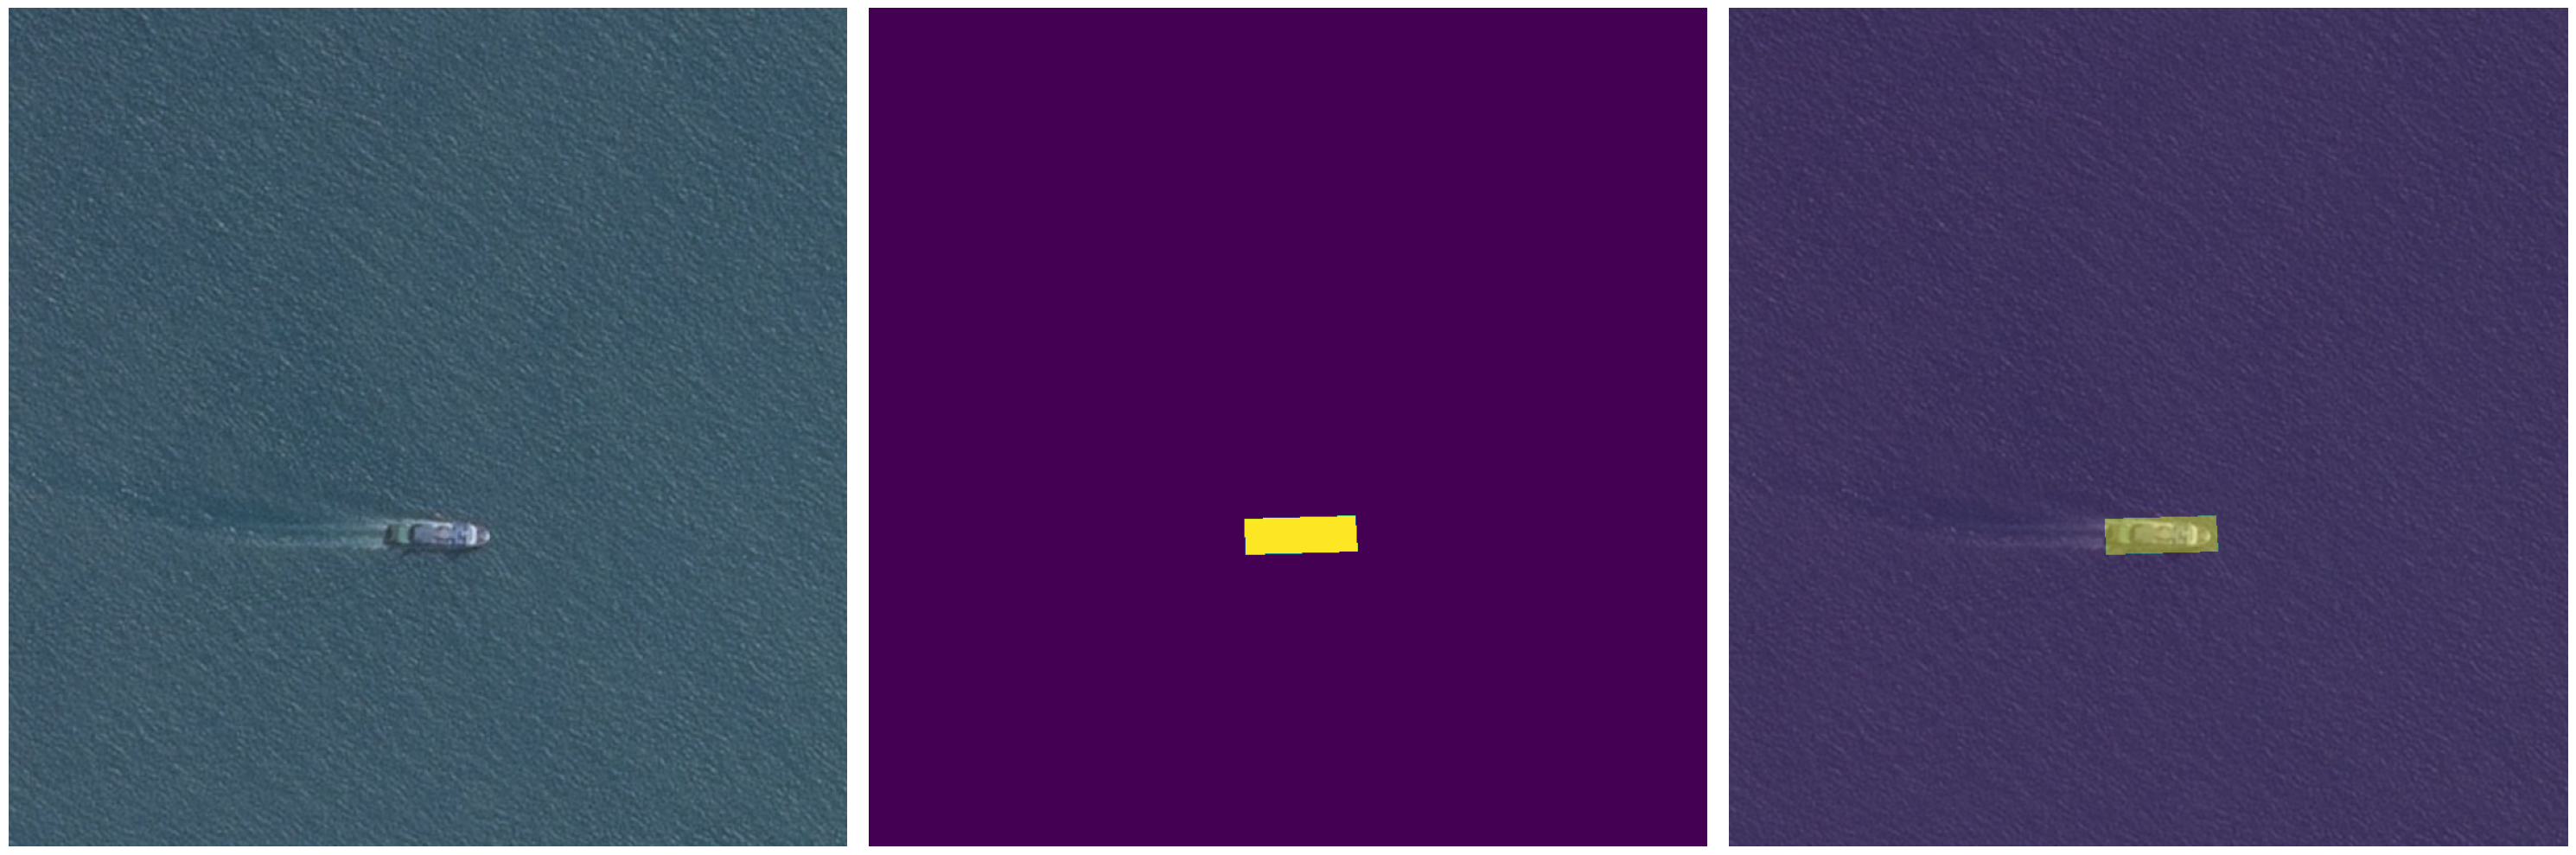

In [15]:
# Example
plot_exmaples(['000155de5.jpg'])

In [16]:
imgid_list = balanced_mask_df['ImageId'].unique()
len(imgid_list)

57556

In [19]:
# Lets group out images by the numer of ships on them
# First, add an "counter" column ShipCount
masks['ShipCount'] = masks.apply(lambda x: 1 if x['EncodedPixels'] != 0 else 0, axis = 1)
masks

,ImageId,EncodedPixels,ShipCount
0,00003e153.jpg,0,0
1,0001124c7.jpg,0,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,0,0
231719,ffff2aa57.jpg,0,0
231720,ffff6e525.jpg,0,0
231721,ffffc50b4.jpg,0,0


In [20]:
# Same with balanced df

balanced_mask_df['ShipCount'] = balanced_mask_df.apply(lambda x: 1 if x['EncodedPixels'] != 0 else 0, axis = 1)
balanced_mask_df

,ImageId,EncodedPixels,ShipCount
145856,a0f9526a9.jpg,0,0
109334,7869d5bdd.jpg,76623 1 77388 5 78153 9 78919 11 79687 11 8045...,1
120173,849ab5fc3.jpg,308655 4 309423 11 310191 15 310958 16 311726 ...,1
142790,9d8572e25.jpg,489137 6 489905 16 490673 26 491441 36 492209 ...,1
178713,c5683c938.jpg,548319 3 549082 8 549844 14 550607 20 551370 2...,1
...,...,...,...
48428,35e9afe12.jpg,349396 1 350163 3 350931 4 351698 6 352465 8 3...,1
112915,7c812db1d.jpg,454457 1 455225 3 455992 6 456760 8 457527 11 ...,1
87052,601bdf33e.jpg,348046 1 348813 3 349580 5 350347 7 351114 9 3...,1
215725,ee69b6671.jpg,542183 1 542951 2 543718 5 544485 7 545252 9 5...,1


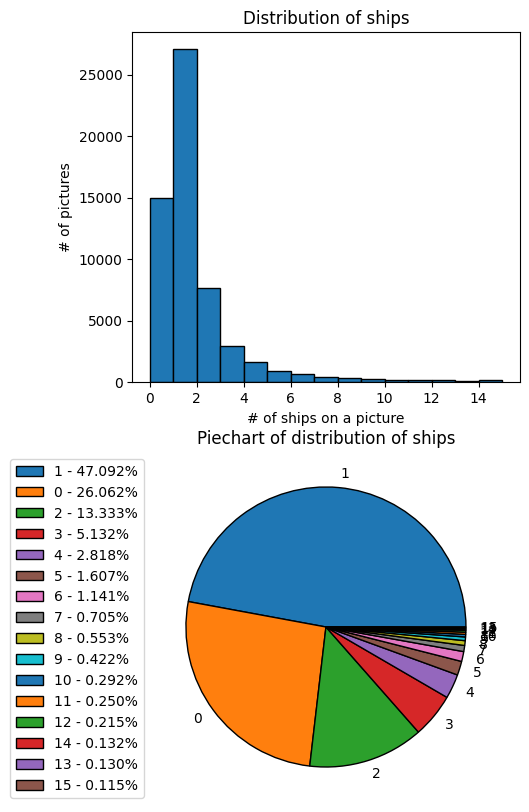

In [22]:
# Plot the distribution of # ships in out data  


ships_numbers = balanced_mask_df[['ImageId','ShipCount']].groupby(['ImageId']).sum()
# ships_numbers = masks[['ImageId','ShipCount']].groupby(['ImageId']).sum()

fig, axs = plt.subplots(2, 1, figsize = (5, 10))
axs[0].hist(ships_numbers, bins = 15, histtype='bar', ec='black')
axs[0].set_title('Distribution of ships')
axs[0].set_xlabel('# of ships on a picture')
axs[0].set_ylabel('# of pictures')

axs[1].pie(
    ships_numbers.value_counts(normalize=True),
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True},
    labels = ships_numbers.value_counts().index.get_level_values(0))
legend = [f'{i} - {j:1.3f}%' for i,j in zip(ships_numbers.value_counts().index.get_level_values(0), ships_numbers.value_counts(normalize=True).values * 100)]
axs[1].legend(legend, bbox_to_anchor=(0.0, 1.0))
axs[1].set_title('Piechart of distribution of ships')


plt.show()

In [ ]:
# Plot examples of images with different numer of ships

num_ship_example = [0, 1, 3, 5, 7, 10, 15]

for n_ships in num_ship_example:
    example_df = ships_numbers[ships_numbers['ShipCount'] == n_ships].sample(n = 3)
    plot_exmaples(example_df.index.to_list())

## Explore color distribution

In [300]:
def get_image(img_path):
    train_folder = 'train_v2'
    return cv2.imread(os.path.join(train_folder, img_path))

# Function that plots color distibution of images without and with ships
def color_dist_s_ns():
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
    fig.set_size_inches(20, 6)

    for i, rows in enumerate([ships_numbers[ships_numbers['ShipCount'] == 0], ships_numbers[ships_numbers['ShipCount'] != 0]]):

        selected_rows = rows.sample(250)

        imgs = np.array([get_image(path) for path in selected_rows.index])

        red_dist = np.bincount(imgs[:,:,:,2].ravel())
        green_dist = np.bincount(imgs[:,:,:,1].ravel())
        blue_dist = np.bincount(imgs[:,:,:,0].ravel())

        ax[i].plot(red_dist/np.sum(red_dist), color='red', label='red', lw=2)
        ax[i].plot(green_dist/np.sum(green_dist), color='green', label='green', lw=2)
        ax[i].plot(blue_dist/np.sum(blue_dist), color='blue', label='blue', lw=2)
        ax[i].legend()


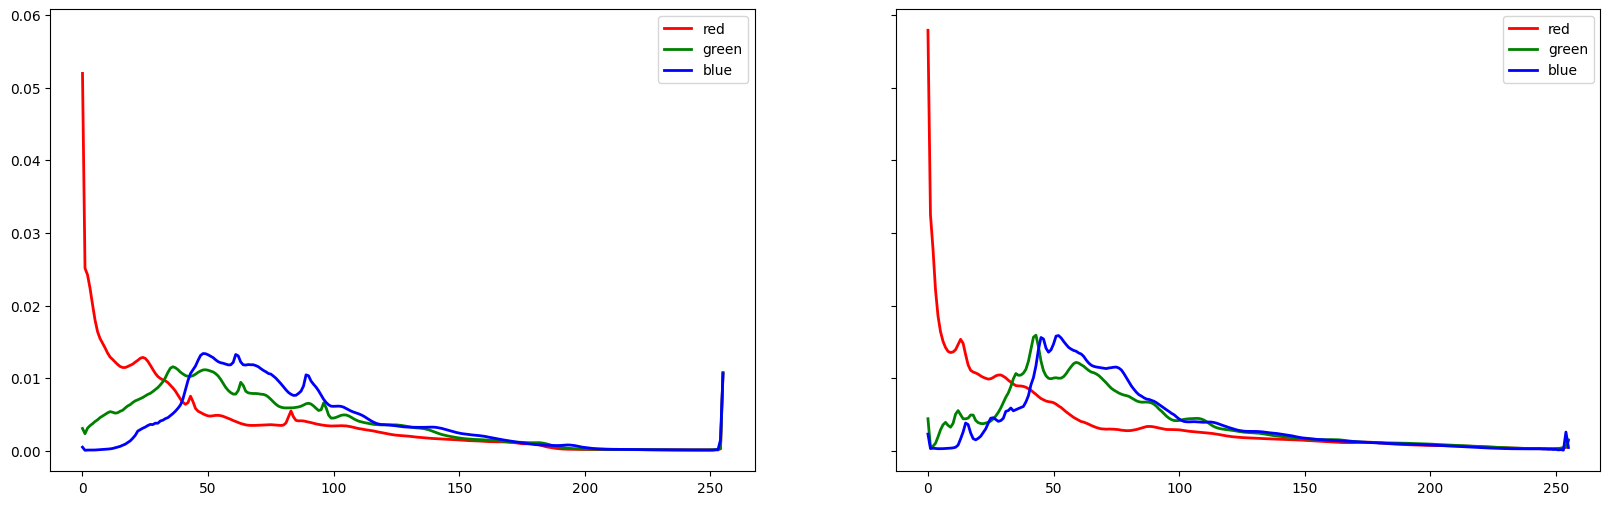

In [301]:
# Ships are often small, so we cannot obserse a sifnificant differences
# All present differences may not exceed random fluctuations

color_dist_s_ns()

In [417]:
def apply_mask(ImageId):
    img = cv2.imread('train_v2\\' + ImageId)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)

    img[all_masks == 0] = [0, 0, 0]

    return img

# Function that plots color distibution of ships
def ships_color_dist():

    sampled_rows = ships_numbers[ships_numbers['ShipCount'] != 0].sample(100).index

    stacked_masked_imgs = np.array([apply_mask(ImageId) for ImageId in sampled_rows])

    stacked_masked_imgs = stacked_masked_imgs.reshape(-1, 3)

    non_black_pxl_mask = np.all(stacked_masked_imgs != [0, 0, 0], axis=-1)

    non_black_pixels = stacked_masked_imgs[non_black_pxl_mask]

    red_dist = np.bincount(non_black_pixels[:,2].ravel())
    green_dist = np.bincount(non_black_pixels[:,1].ravel())
    blue_dist = np.bincount(non_black_pixels[:,0].ravel())


    plt.plot(red_dist/np.sum(red_dist), color='red', label='red', lw=2)
    plt.plot(green_dist/np.sum(green_dist), color='green', label='green', lw=2)
    plt.plot(blue_dist/np.sum(blue_dist), color='blue', label='blue', lw=2)
    plt.legend()
    plt.show()

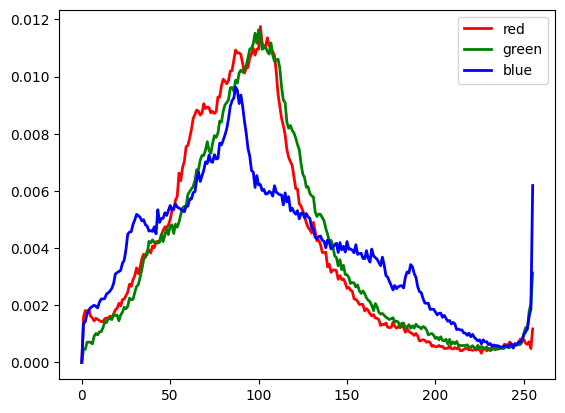

In [418]:
# As we can see, color distribution of ships are very different from images. The ships on images are distinguishable

ships_color_dist()